<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Desaf%C3%ADo_3_Predicci%C3%B3n_de_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío 3 - Predicción de churn

**Nombre**: Pablo Saavedra <br />
**Curso**: Machine Learning (G105)


---

### Importación de librerías

In [90]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.multiclass import type_of_target

from imblearn.over_sampling import SMOTE

# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format


### Funciones útiles

In [124]:
def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i])
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


## 1. Análisis de los datos

Realizar un análisis exploratorio de los datos para comprender las características y la distribución de los datos.

#### Carga de datos

In [12]:
df = pd.read_excel('/content/drive/MyDrive/Telco-Customer-Churn.xlsx')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [13]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,"1,889.50",No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,"1,840.75",No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Análisis

In [14]:
print(f"Número de registros nulos:\n{df.isnull().sum()}")
print(f"Número de registros NaN:\n{df.isna().sum()}")

Número de registros nulos:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
Número de registros NaN:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges   

> Existen 11 registros nulos en la columna TotalCharges. Se procede a eliminar los registros:



In [15]:
df = df.dropna()

 > Además el valor TotalCharges es de tipo object, sin embargo es un número. Por lo tanto, se procede a convertir a tipo número

In [16]:
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

In [17]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,"7,032.00","7,032.00","7,032.00","7,032.00"
mean,0.16,32.42,64.80,"2,283.30"
std,0.37,24.55,30.09,"2,266.77"
min,0.00,1.00,18.25,18.80
25%,0.00,9.00,35.59,401.45
50%,0.00,29.00,70.35,"1,397.47"
75%,0.00,55.00,89.86,"3,794.74"
max,1.00,72.00,118.75,"8,684.80"


> Obtener las columnas de los datos cuantitativos y cualitativos:

In [18]:
variables_cualitativas = df.drop(['Churn'], axis=1).select_dtypes(include="object").columns.to_list()
variables_cuantitativas = df.select_dtypes(include="number").columns.to_list()

#### Outliers

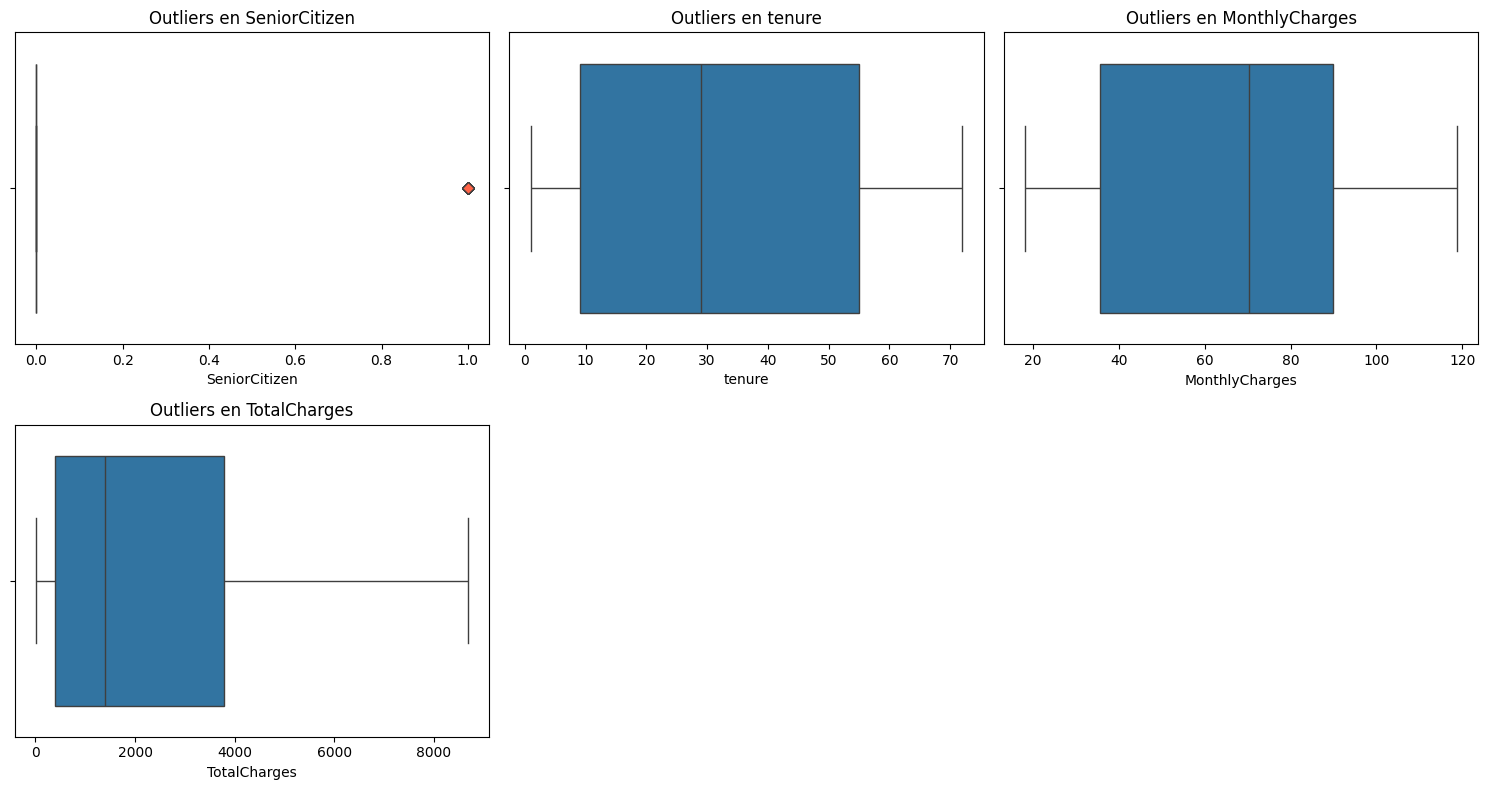

In [19]:
plot_outliers(df, variables_cuantitativas)

In [20]:
df['SeniorCitizen'].value_counts()

,count
SeniorCitizen,
0,5890
1,1142


> De lo anterior podemos advertir que:
> - La columna SeniorCitizen parece ser una variable cualitativa
> - No se observan outliers

In [21]:
# Se actualizan los tipos de variables
variables_cualitativas.append('SeniorCitizen')
variables_cuantitativas.remove('SeniorCitizen')
variables_cualitativas.remove('customerID')

#### Distribución de datos

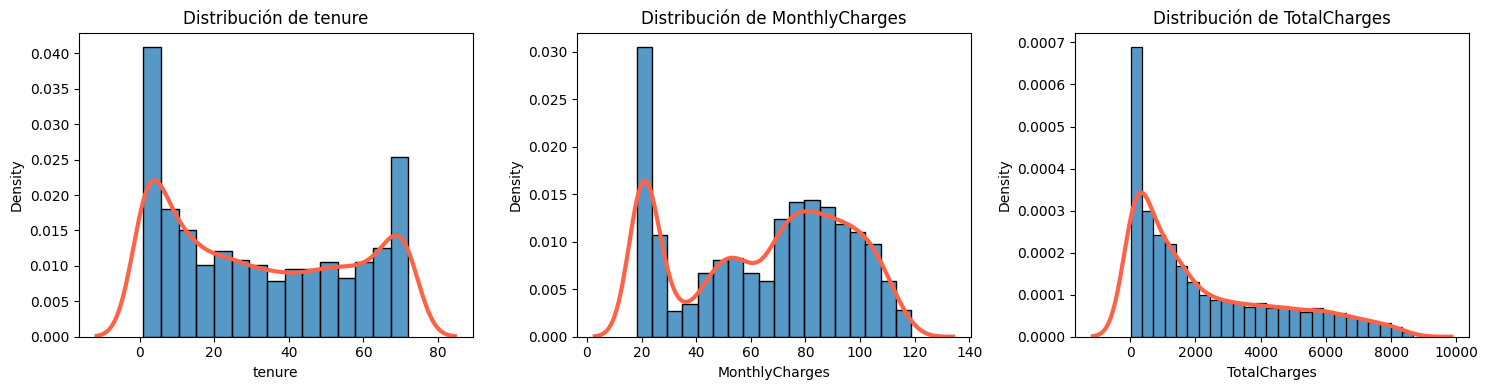

In [22]:
plot_hist(df, variables_cuantitativas)

> Conclusiones:
> - Los datos de tenure tiene al perecer 2 medias.
> - Totalcharges tiene una distribución corrida hacia la izquierda.

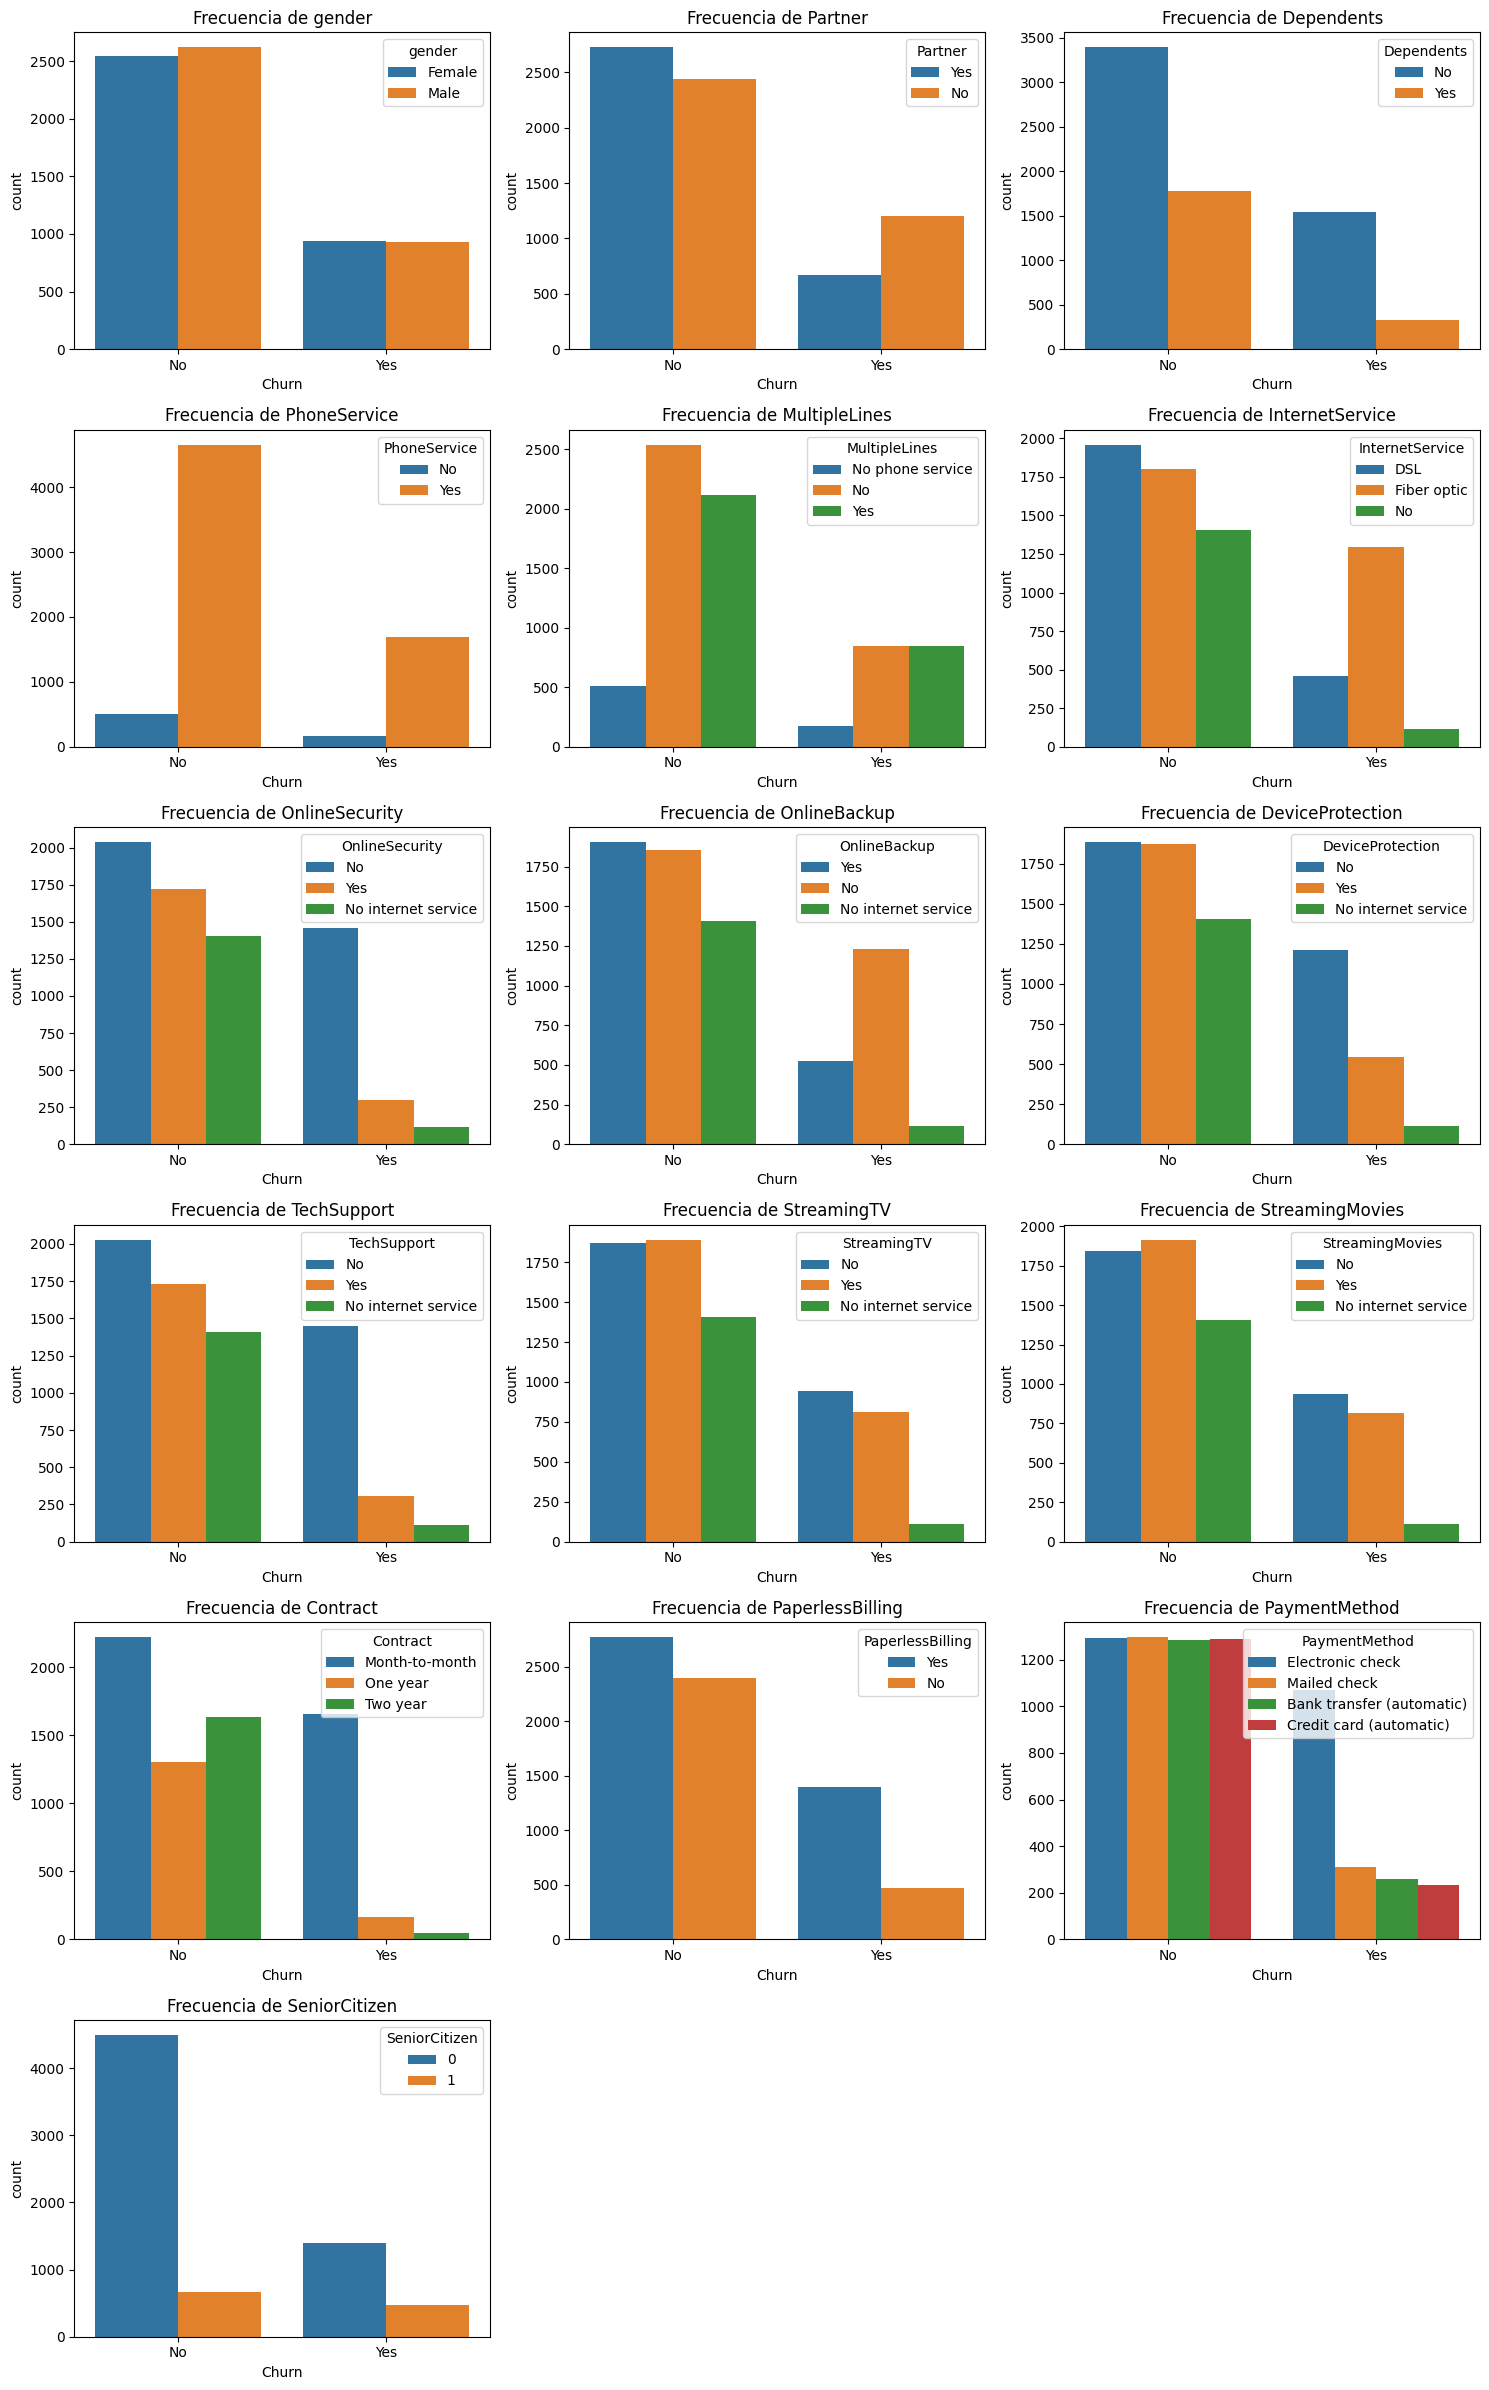

In [23]:
plot_count(df, variables_cualitativas, _X="Churn")

> Conclusiones
> - Partner, InternetServices, OnlineBackup, Contract y PaymentMethod tienen una distribución diferente entre los conjuntos de clientes que se fugan o no (Churn).
> - Se nota un desvalance entre los clientes que se fugan y no (Churn).
> - Los clientes que se fugan tienen una menor cantidad de contratos largos (Contract).
> - Los clientes que se fugan no tienen servicios de seguridad y backup online (OnlineSecurity y OnlineBackup).

#### Correlación

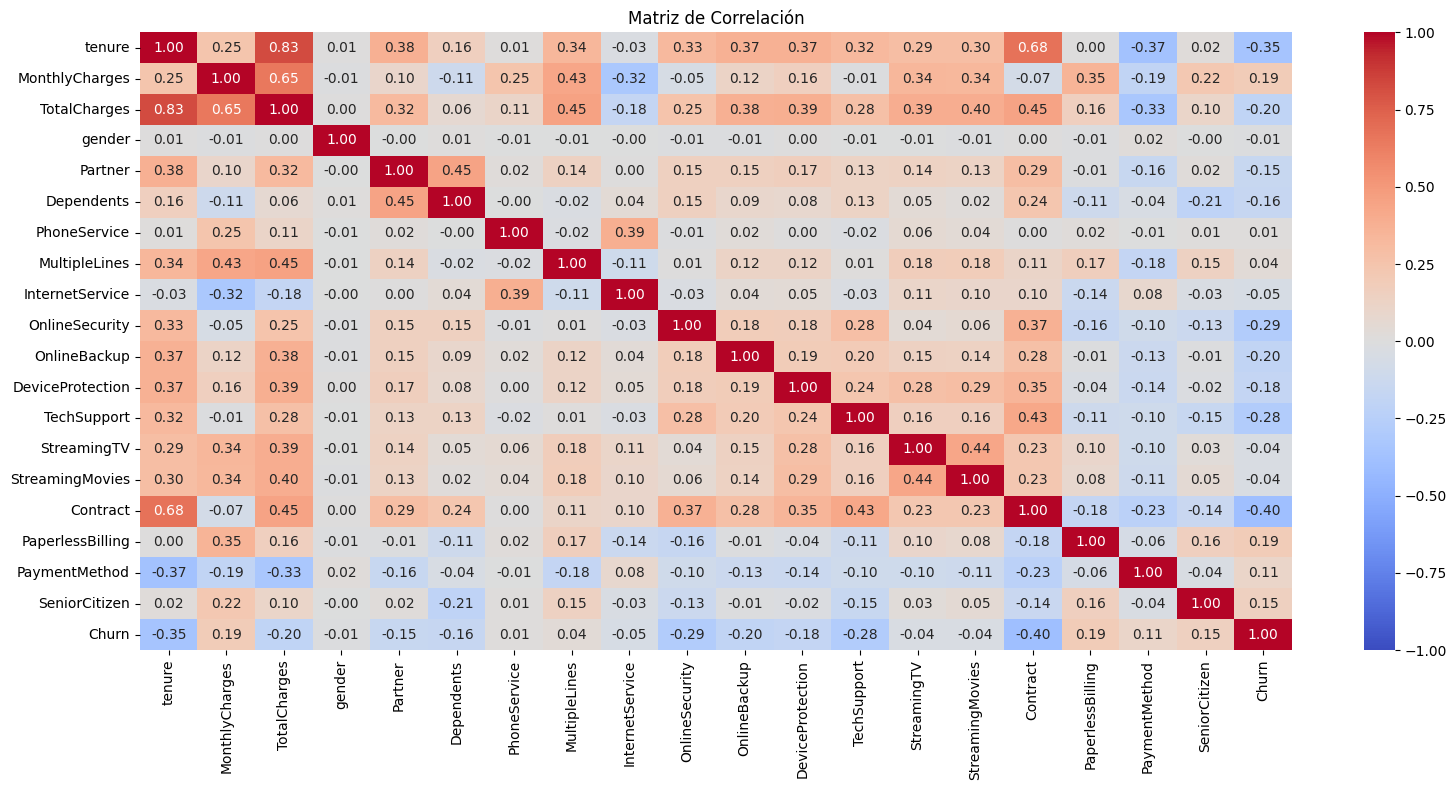

In [24]:
le = preprocessing.LabelEncoder()
df_cat = df[variables_cualitativas + ['Churn']].apply(le.fit_transform)
df_num = df[variables_cuantitativas]
df2 = pd.concat([df_num, df_cat], axis=1)

matriz_correlacion = df2.corr()

plt.figure(figsize=(16, 8))

sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f",vmin=-1, vmax=1)
plt.title("Matriz de Correlación")

plt.tight_layout()
plt.show()

> Conclusiones
> - Existe una alta correlación entre los tenure y TotalCharges. Tiene sentido considerando que el tiempo de un cliente es proporcional al total de cargos.
> - No hay una alta corrrelación entre las demás variables y Churn.

## 2 y 3. Preprocesar los datos

2. Preprocesar los datos, incluyendo la limpieza, la transformación y la normalización de las características según sea necesario.

3. Dividir los datos en conjuntos de entrenamiento y prueba.

> Ahora se realiza el cambio de variables cualitativas a númericas para que puedan ser procesadas en los modelos de clasificación con LabelEncoder

In [25]:
le = preprocessing.LabelEncoder()
df_cat = df[variables_cualitativas].apply(le.fit_transform)
df_num = df[variables_cuantitativas]
df_transform = pd.concat([df_cat, df_num,df['Churn']], axis=1)

df_transform.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   Partner           7032 non-null   int64  
 2   Dependents        7032 non-null   int64  
 3   PhoneService      7032 non-null   int64  
 4   MultipleLines     7032 non-null   int64  
 5   InternetService   7032 non-null   int64  
 6   OnlineSecurity    7032 non-null   int64  
 7   OnlineBackup      7032 non-null   int64  
 8   DeviceProtection  7032 non-null   int64  
 9   TechSupport       7032 non-null   int64  
 10  StreamingTV       7032 non-null   int64  
 11  StreamingMovies   7032 non-null   int64  
 12  Contract          7032 non-null   int64  
 13  PaperlessBilling  7032 non-null   int64  
 14  PaymentMethod     7032 non-null   int64  
 15  SeniorCitizen     7032 non-null   int64  
 16  tenure            7032 non-null   int64  
 17  

In [26]:
df_transform.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0,1,29.85,29.85,No
1,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0,34,56.95,"1,889.50",No
2,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,0,2,53.85,108.15,Yes
3,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0,45,42.30,"1,840.75",No
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,0,2,70.70,151.65,Yes


In [27]:
X = df_transform.drop(['Churn'], axis=1)
y = df_transform['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print("-"*80)
print("Cantidad de usuarios por cada clase:")
print("-"*80)
print(y.value_counts())
print("-"*80)
print("Porcentaje por clase:")
print("-"*80)
print(y.value_counts() * 100 / len(y))

--------------------------------------------------------------------------------
Cantidad de usuarios por cada clase:
--------------------------------------------------------------------------------
Churn
No     5163
Yes    1869
Name: count, dtype: int64
--------------------------------------------------------------------------------
Porcentaje por clase:
--------------------------------------------------------------------------------
Churn
No    73.42
Yes   26.58
Name: count, dtype: float64


> La distribución de las clases no están equilibrados, el porcentaje de etiquetas Yes (cliente que se fuga) son de solo 26.58%. Para equilibrar la cantidad de datos por clase se utilizará SMOTE para generar un sobre muestreo con datos sintéticos y equilibar ambas clases.  

In [29]:
oversample = SMOTE(k_neighbors=5)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)
X_train, y_train = X_smote, y_smote

In [30]:
y_train.value_counts()

,count
Churn,
Yes,4130
No,4130


> Ahora las clases de los datos de entrenamiento tienen la misma cantidad de elementos y por tanto no habrá una sobre estimación del modelo

## 4. Modelos de clasificación


Entrenar al menos 3 algoritmos y optimizar sus hiperparametros

In [36]:
# Obtener las clases
class_names = y.unique().tolist()
# Validación cruzada estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

['No', 'Yes']

### 4.a Árboles de decisión

> Entrenamiento

In [45]:
dt = DecisionTreeClassifier(random_state=42)

# Búsqueda de hiperparámetros (GridSearchCV)
param_grid = {
  "max_depth": [None, 5, 8, 12, 16],
  "min_samples_leaf": [1, 5, 10, 20, 0.01, 0.02, 0.05],
  "min_samples_split": [2, 5, 10, 20, 40],
  "max_features": [None, "sqrt", "log2"],
  "criterion": ["gini", "entropy"],
  "ccp_alpha": [0.0, 1e-4, 5e-4, 1e-3]
}

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Evaluación de los mejores parámetros
best_params = grid.best_params_
best_score = grid.best_score_
print("Mejores hiperparámetros:", best_params)
print("Puntaje del modelo con los mejores hiperparámetros:", best_score)

# Mejor modelo
best_dt = grid.best_estimator_


Mejores hiperparámetros: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 20}
Puntaje del modelo con los mejores hiperparámetros: 0.8152542372881356


> Evaluación

In [84]:
y_pred_train = best_dt.predict(X_train)
y_pred = best_dt.predict(X_test)

print(f"\nAccuracy en train: {accuracy_score(y_train, y_pred_train):.3f}")
print("\nReporte de clasificación en train:")
print(classification_report(y_train, y_pred_train, digits=3))


Accuracy en train: 0.835

Reporte de clasificación en train:
              precision    recall  f1-score   support

          No      0.833     0.839     0.836      4130
         Yes      0.838     0.832     0.835      4130

    accuracy                          0.835      8260
   macro avg      0.835     0.835     0.835      8260
weighted avg      0.835     0.835     0.835      8260



### 4.b Naive Bayes

> Entrenamiento

In [131]:
class HybridMixedNB(BaseEstimator, ClassifierMixin):
    def __init__(self, num_pipe=None, cat_pipe=None):
        self.num_pipe = num_pipe
        self.cat_pipe = cat_pipe

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        if self.num_pipe is not None:
            self.num_pipe_ = clone(self.num_pipe).fit(X, y)
        if self.cat_pipe is not None:
            self.cat_pipe_ = clone(self.cat_pipe).fit(X, y)
        return self

    def _logsumexp(self, Z):
        # Z: (n_samples, n_classes)
        m = np.max(Z, axis=1, keepdims=True)
        return m + np.log(np.exp(Z - m).sum(axis=1, keepdims=True))

    def predict_log_proba(self, X):
        # Sumamos log-probabilidades de cada componente (independencia condicional)
        # Nota: asumimos que ambos componentes fueron entrenados con el mismo y,
        # por lo que el orden de clases es consistente.
        logs = None

        if hasattr(self, "num_pipe_"):
            lp_num = self.num_pipe_.predict_log_proba(X)  # (n, C)
            logs = lp_num if logs is None else (logs + lp_num)

        if hasattr(self, "cat_pipe_"):
            lp_cat = self.cat_pipe_.predict_log_proba(X)  # (n, C)
            logs = lp_cat if logs is None else (logs + lp_cat)

        if logs is None:
            raise RuntimeError("No hay componentes entrenados (num_pipe_ y cat_pipe_ son None).")

        # Normalización estable: log p = log p - logsumexp(log p)
        lse = self._logsumexp(logs)
        return logs - lse

    def predict_proba(self, X):
        # p = exp(log p) — ya normalizado
        return np.exp(self.predict_log_proba(X))

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_log_proba(X), axis=1)]


num_pipe = Pipeline([
    ("sel", ColumnTransformer([("num", "passthrough", variables_cuantitativas)], remainder="drop")),
    ("sc", StandardScaler()),
    ("gnb", GaussianNB(var_smoothing=1e-9)),
])

cat_pipe = Pipeline([
    ("sel", ColumnTransformer([
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), variables_cualitativas)
    ], remainder="drop")),
    ("cnb", CategoricalNB(alpha=1.0))
])

pipenb = HybridMixedNB(num_pipe=num_pipe, cat_pipe=cat_pipe)

# Búsqueda de hiperparámetros (GridSearchCV)
param_grid = {
    "num_pipe__gnb__var_smoothing": np.logspace(-25, -6, 8),  # 1e-12 ... 1e-6
    "cat_pipe__cnb__alpha": [0.1, 0.5, 1.0, 2.0]
}

grid = GridSearchCV(
    estimator=pipenb,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Evaluación de los mejores parámetros
best_params = grid.best_params_
best_score = grid.best_score_
print("Mejores hiperparámetros:", best_params)
print("Puntaje del modelo con los mejores hiperparámetros:", best_score)

# Mejor modelo
best_nb = grid.best_estimator_

Mejores hiperparámetros: {'cat_pipe__cnb__alpha': 0.1, 'num_pipe__gnb__var_smoothing': np.float64(1e-25)}
Puntaje del modelo con los mejores hiperparámetros: 0.771186440677966


> Evaluación

In [132]:
y_pred_train = best_nb.predict(X_train)
y_pred = best_nb.predict(X_test)

print(f"\nAccuracy en train: {accuracy_score(y_train, y_pred_train):.3f}")
print("\nReporte de clasificación en train:")
print(classification_report(y_train, y_pred_train, digits=3))


Accuracy en train: 0.772

Reporte de clasificación en train:
              precision    recall  f1-score   support

          No      0.803     0.719     0.759      4130
         Yes      0.746     0.824     0.783      4130

    accuracy                          0.772      8260
   macro avg      0.775     0.772     0.771      8260
weighted avg      0.775     0.772     0.771      8260



### 4.c Regresión Logística

> Entrenamiento

In [92]:
# Escalado -> LR
pipelr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000, solver="saga", penalty="l2"))
])

# Búsqueda de hiperparámetros (GridSearchCV)
param_grid = [
    # L1
    {"lr__penalty": ["l1"],
     "lr__C": np.logspace(-3, 2, 6),
     "lr__solver": ["liblinear", "saga"]},

    # L2
    {"lr__penalty": ["l2"],
     "lr__C": np.logspace(-3, 2, 6),
     "lr__solver": ["lbfgs", "liblinear", "saga", "newton-cg", "sag"]},

    # Elastic Net (requiere l1_ratio y saga)
    {"lr__penalty": ["elasticnet"],
     "lr__C": np.logspace(-3, 2, 6),
     "lr__l1_ratio": [0.2, 0.5, 0.8],
     "lr__solver": ["saga"]},

    # Sin regularización
    {"lr__penalty": [None],
     "lr__solver": ["lbfgs", "saga", "newton-cg", "sag"]},
]

grid = GridSearchCV(
    estimator=pipelr,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Evaluación de los mejores parámetros
best_params = grid.best_params_
best_score = grid.best_score_
print("Mejores hiperparámetros:", best_params)
print("Puntaje del modelo con los mejores hiperparámetros:", best_score)

# Mejor modelo
best_lr = grid.best_estimator_

Mejores hiperparámetros: {'lr__C': np.float64(0.01), 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Puntaje del modelo con los mejores hiperparámetros: 0.8058111380145278


> Evaluación

In [79]:
y_pred_train = best_lr.predict(X_train)
y_pred = best_lr.predict(X_test)

print(f"\nAccuracy en train: {accuracy_score(y_train, y_pred_train):.3f}")
print("\nReporte de clasificación en train:")
print(classification_report(y_train, y_pred_train, digits=3))


Accuracy en train: 0.807

Reporte de clasificación en train:
              precision    recall  f1-score   support

          No      0.830     0.773     0.800      4130
         Yes      0.787     0.841     0.814      4130

    accuracy                          0.807      8260
   macro avg      0.809     0.807     0.807      8260
weighted avg      0.809     0.807     0.807      8260



## 5. Evaluar modelos

Evaluar el rendimiento de los modelos utilizando métricas de evaluación pertinentes, como precisión, sensibilidad, valor F1, entre otras.

### Árbol de decisión (DT)

Árbol de decisión Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      0.833     0.839     0.836      4130
           1      0.838     0.832     0.835      4130

    accuracy                          0.835      8260
   macro avg      0.835     0.835     0.835      8260
weighted avg      0.835     0.835     0.835      8260

Árbol de decisión Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.852     0.805     0.828      1033
           1      0.533     0.612     0.570       374

    accuracy                          0.754      1407
   macro avg      0.692     0.709     0.699      1407
weighted avg      0.767     0.754     0.759      1407



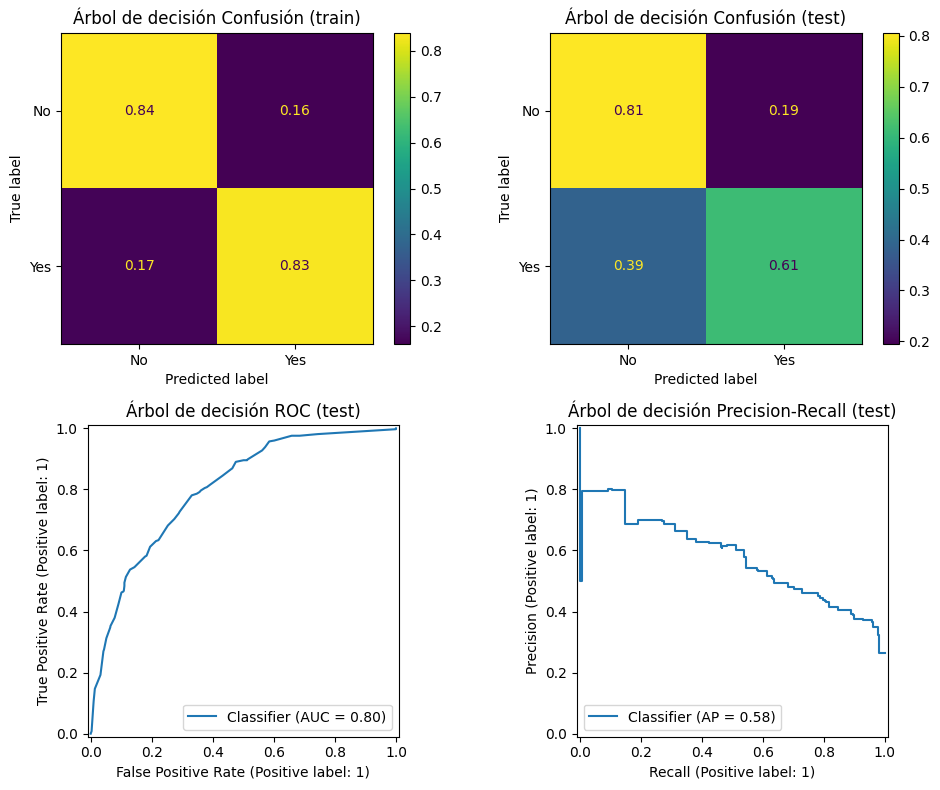

{'train_accuracy': 0.8353510895883777,
 'train_balanced_accuracy': np.float64(0.8353510895883778),
 'train_precision_weighted': 0.8353665043084839,
 'train_recall_weighted': 0.8353510895883777,
 'train_f1_weighted': 0.8353491975940955,
 'train_mcc': np.float64(0.6707175937197277),
 'test_accuracy': 0.7540867093105899,
 'test_balanced_accuracy': np.float64(0.7088602844112212),
 'test_precision_weighted': 0.7667843550705076,
 'test_recall_weighted': 0.7540867093105899,
 'test_f1_weighted': 0.759225195981712,
 'test_mcc': np.float64(0.4005809691526588),
 'train_roc_auc': np.float64(0.9187447015577273),
 'test_roc_auc': np.float64(0.8007387237214696),
 'train_pr_auc': np.float64(0.9149580363208258),
 'test_pr_auc': np.float64(0.5771543696133727)}

In [126]:
eval_model(best_dt, X_train, y_train, X_test, y_test, class_names, title_prefix="Árbol de decisión", label_map={"No": 0, "Yes": 1})

### Naive Bayes (NB)

Naive Bayes Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      0.803     0.719     0.759      4130
           1      0.746     0.824     0.783      4130

    accuracy                          0.772      8260
   macro avg      0.775     0.772     0.771      8260
weighted avg      0.775     0.772     0.771      8260

Naive Bayes Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.893     0.709     0.790      1033
           1      0.487     0.765     0.595       374

    accuracy                          0.724      1407
   macro avg      0.690     0.737     0.693      1407
weighted avg      0.785     0.724     0.738      1407



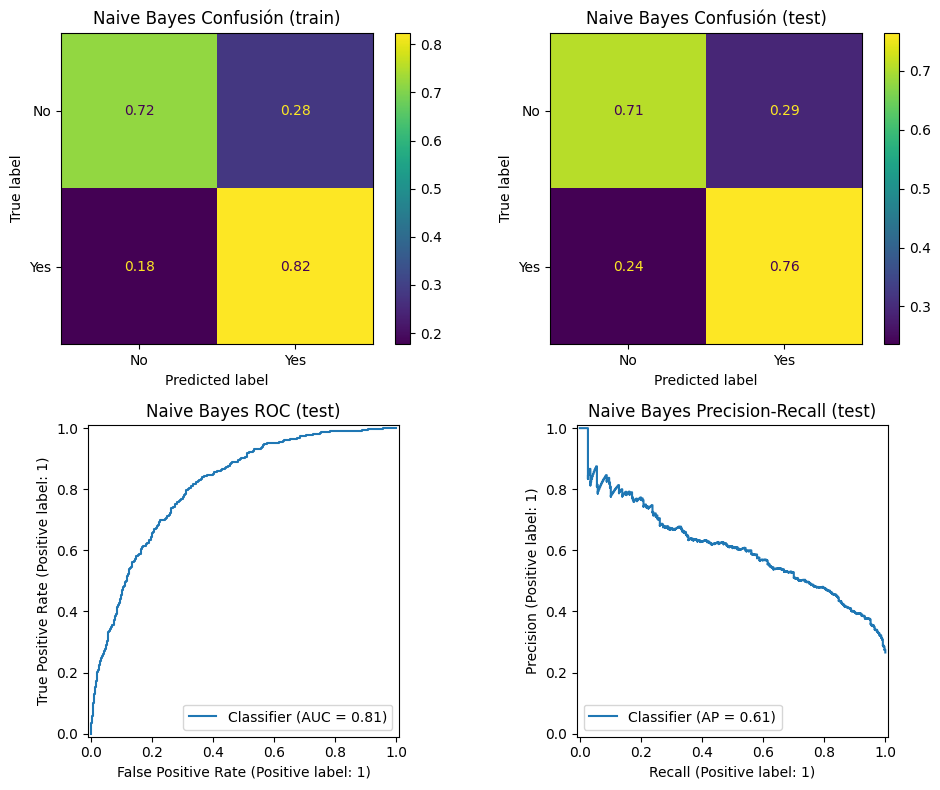

{'train_accuracy': 0.7715496368038741,
 'train_balanced_accuracy': np.float64(0.7715496368038741),
 'train_precision_weighted': 0.7745395553910143,
 'train_recall_weighted': 0.7715496368038741,
 'train_f1_weighted': 0.7709259445500879,
 'train_mcc': np.float64(0.5460810070116959),
 'test_accuracy': 0.7235252309879175,
 'test_balanced_accuracy': np.float64(0.73666078241558),
 'test_precision_weighted': 0.7849061325453413,
 'test_recall_weighted': 0.7235252309879175,
 'test_f1_weighted': 0.7382745224912535,
 'test_mcc': np.float64(0.42404922780629944),
 'train_roc_auc': np.float64(0.8493408239480797),
 'test_roc_auc': np.float64(0.813095651003515),
 'train_pr_auc': np.float64(0.8266147311355849),
 'test_pr_auc': np.float64(0.6080833178032091)}

In [134]:
eval_model(best_nb, X_train, y_train, X_test, y_test, class_names, title_prefix="Naive Bayes", label_map={"No": 0, "Yes": 1})

### Regresión Logística (LR)

Regresión Logística Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      0.830     0.773     0.800      4130
           1      0.787     0.841     0.814      4130

    accuracy                          0.807      8260
   macro avg      0.809     0.807     0.807      8260
weighted avg      0.809     0.807     0.807      8260

Regresión Logística Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.875     0.753     0.810      1033
           1      0.508     0.703     0.590       374

    accuracy                          0.740      1407
   macro avg      0.691     0.728     0.700      1407
weighted avg      0.777     0.740     0.751      1407



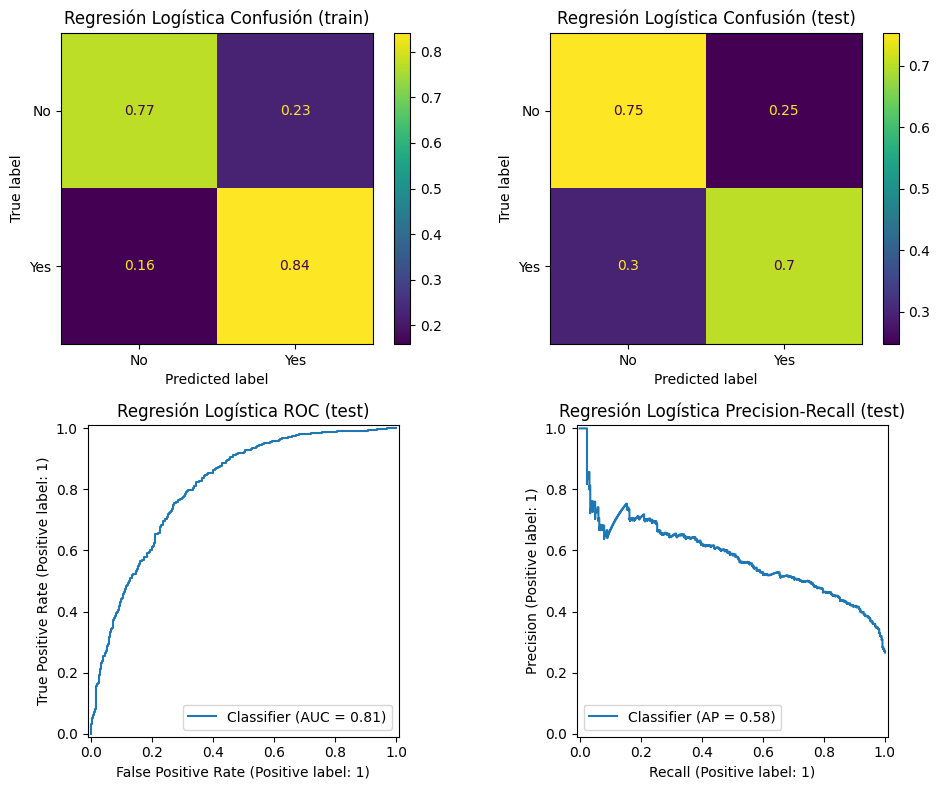

{'train_accuracy': 0.8071428571428572,
 'train_balanced_accuracy': np.float64(0.8071428571428572),
 'train_precision_weighted': 0.8085918197475368,
 'train_recall_weighted': 0.8071428571428572,
 'train_f1_weighted': 0.8069162056410248,
 'train_mcc': np.float64(0.615732972020086),
 'test_accuracy': 0.7398720682302772,
 'test_balanced_accuracy': np.float64(0.7281773661677995),
 'test_precision_weighted': 0.777475677581448,
 'test_recall_weighted': 0.7398720682302772,
 'test_f1_weighted': 0.751124294879019,
 'test_mcc': np.float64(0.4179966103406781),
 'train_roc_auc': np.float64(0.8859409681712387),
 'test_roc_auc': np.float64(0.809873117600468),
 'train_pr_auc': np.float64(0.876383435052959),
 'test_pr_auc': np.float64(0.5814346283093944)}

In [130]:
eval_model(best_lr, X_train, y_train, X_test, y_test, class_names, title_prefix="Regresión Logística", label_map={"No": 0, "Yes": 1})

### Conclusiones finales

* **Rendimiento global (test)**:

  * **Accuracy / F1_weighted**: **DT** lidera levemente (0.754 / 0.759), **LR** muy cerca (0.740 / 0.751), **NB** atrás (0.724 / 0.738).
  * **MCC (robusta a desbalance)**: muy parejos: **NB 0.424** ≈ **LR 0.418** > **DT 0.401**.

* **Desbalance por clase**:

  * **Balanced accuracy**: **NB** mejor (0.737), luego **LR** (0.728), **DT** (0.709). NB maneja mejor el desbalance.

* **Probabilidades / ranking**:

  * **AUC-ROC**: **LR** (0.810) ≈ **DT** (0.801).
  * **PR-AUC**:
     * Clase positiva escasa (26.58%)
     * **DT** y **LR** ambos bajos (0.58) y similares.

* **Sobreajuste (gap train–test)**:

  * Mayor en **DT** (0.08), luego **LR** (0.07), menor en **NB** (0.05).

**Conclusión**

* Si se requiere una mayor precisión (**F1/accuracy**) la opción es **Árbol de decisión (DT)**, pero tiene más de sobreajuste (se prodría mejorar podando el árbol).
* Si se necesita priorizar **equilibrio entre clases** (balanced acc) el modelo **Naive Bayes (NB)**.
---


## Recomendación

> Debido a que el objetivo es retener a los clientes que potencialmente se fugarían es necesario seleccionar el modelo que mejor detecté a este grupo y que también no lo sobreestime para evitar perder recursos y esfuerzos en falsos positivos. En este caso el modelo que mejor se comporta es **Naive Bayes (NB)**, modelo que tiene el mejor balance entre los modelos evaluados.
>
> Por otro lado, se pueden usar la salida de probabilidad del modelo para poder subclasificar a los potenciales clientes que se fugaran y matizar los esfuerzos de retención según la probabilidad de salida.